In [1]:
# Install PyTorch Geometric and other dependencies
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
!pip install torch_geometric

  Using cached torch_geometric-2.5.3-py3-none-any.whl (1.1 MB)


In [35]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the cleaned data
data = pd.read_csv('/content/drive/MyDrive/data_cleaned.csv')

# Separate features and target
X = data.drop(columns=['MEDV'])
y = data['MEDV']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create Data objects
data_list = []
for i in range(len(X)):
    node_features = torch.tensor(X[i], dtype=torch.float).view(1, -1)
    label = torch.tensor([y[i]], dtype=torch.float)

    # Create a self-loop edge index for each individual data point
    edge_index = torch.tensor([[0], [0]], dtype=torch.long)

    data_list.append(Data(x=node_features, edge_index=edge_index, y=label))


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

input_dim = X.shape[1]
hidden_dim = 64
output_dim = 1

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [20]:
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=13)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [21]:
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            loss = criterion(out, data.y)
            losses.append(loss.item())
    return np.mean(losses)


In [22]:
for epoch in range(200):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    train_losses.append(train_loss)
    test_losses.append(test_loss)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Train Loss: 36.6896, Test Loss: 35.0311
Epoch: 2, Train Loss: 30.8555, Test Loss: 44.7945
Epoch: 3, Train Loss: 20.3850, Test Loss: 24.6284
Epoch: 4, Train Loss: 16.5835, Test Loss: 20.3016
Epoch: 5, Train Loss: 13.9547, Test Loss: 19.1381
Epoch: 6, Train Loss: 12.8216, Test Loss: 16.4753
Epoch: 7, Train Loss: 26.6812, Test Loss: 37.8709
Epoch: 8, Train Loss: 13.5657, Test Loss: 18.9123
Epoch: 9, Train Loss: 14.4477, Test Loss: 21.6325
Epoch: 10, Train Loss: 16.6484, Test Loss: 20.7992
Epoch: 11, Train Loss: 14.4783, Test Loss: 20.7330
Epoch: 12, Train Loss: 15.0954, Test Loss: 20.3320
Epoch: 13, Train Loss: 11.3295, Test Loss: 18.0943
Epoch: 14, Train Loss: 17.5891, Test Loss: 22.5932
Epoch: 15, Train Loss: 10.3638, Test Loss: 15.8937
Epoch: 16, Train Loss: 11.9591, Test Loss: 15.9464
Epoch: 17, Train Loss: 16.0317, Test Loss: 20.7279
Epoch: 18, Train Loss: 10.6708, Test Loss: 15.6984
Epoch: 19, Train Loss: 10.8782, Test Loss: 15.7566
Epoch: 20, Train Loss: 11.7383, Test Los

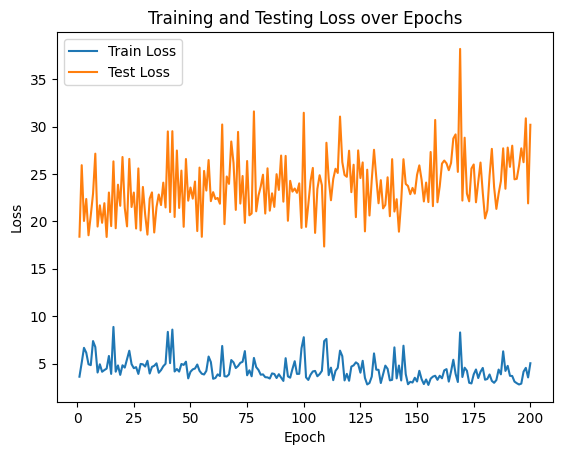

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, 201)
train_losses = []
test_losses = []

for epoch in epochs:
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()


In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import torch.nn as nn

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

input_dim = X.shape[1]
output_dim = 1
heads = 8  # Number of attention heads

In [25]:
learning_rate = 0.005
weight_decay = 1e-4
hidden_dim = 128  # Increase the hidden dimension

model = GAT(input_dim, hidden_dim, output_dim, heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [26]:
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            loss = criterion(out, data.y)
            losses.append(loss.item())
    return np.mean(losses)


In [27]:
train_losses_gat = []
test_losses_gat = []

for epoch in range(400):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    train_losses_gat.append(train_loss)
    test_losses_gat.append(test_loss)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Train Loss: 261.2418, Test Loss: 218.4483
Epoch: 2, Train Loss: 227.6134, Test Loss: 206.0744
Epoch: 3, Train Loss: 126.8036, Test Loss: 110.3824
Epoch: 4, Train Loss: 188.0112, Test Loss: 160.1898
Epoch: 5, Train Loss: 197.8108, Test Loss: 165.8679
Epoch: 6, Train Loss: 177.5093, Test Loss: 151.1282
Epoch: 7, Train Loss: 138.0148, Test Loss: 116.7468
Epoch: 8, Train Loss: 115.6260, Test Loss: 95.7291
Epoch: 9, Train Loss: 119.6043, Test Loss: 106.1004
Epoch: 10, Train Loss: 119.6701, Test Loss: 101.4703
Epoch: 11, Train Loss: 125.9377, Test Loss: 107.1001
Epoch: 12, Train Loss: 108.9202, Test Loss: 90.6313
Epoch: 13, Train Loss: 80.5570, Test Loss: 64.2040
Epoch: 14, Train Loss: 73.2622, Test Loss: 61.7325
Epoch: 15, Train Loss: 71.4741, Test Loss: 57.2941
Epoch: 16, Train Loss: 94.0789, Test Loss: 79.9113
Epoch: 17, Train Loss: 53.0450, Test Loss: 47.9228
Epoch: 18, Train Loss: 74.7373, Test Loss: 60.7046
Epoch: 19, Train Loss: 65.5203, Test Loss: 58.2379
Epoch: 20, Train L

KeyboardInterrupt: 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)
        self.relu = nn.ReLU()

        # Linear layer to match dimensions if needed
        if in_channels != out_channels:
            self.linear = nn.Linear(in_channels, out_channels)
        else:
            self.linear = None

    def forward(self, x, edge_index):
        identity = x
        out = self.conv1(x, edge_index)
        out = self.relu(out)
        out = self.conv2(out, edge_index)

        # Match dimensions if needed
        if self.linear is not None:
            identity = self.linear(identity)

        out += identity
        out = self.relu(out)
        return out


In [41]:
class TransformerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, nhead, num_layers):
        super(TransformerBlock, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x

In [42]:
class CombinedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead, num_layers):
        super(CombinedModel, self).__init__()
        self.resnet_block = ResNetBlock(input_dim, hidden_dim)
        self.transformer_block = TransformerBlock(hidden_dim, hidden_dim, nhead, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.resnet_block(x, edge_index)
        x = x.view(-1, 1, x.size(-1))  # Reshape for transformer [seq_len, batch_size, hidden_dim]
        x = self.transformer_block(x)
        x = x.view(-1, x.size(-1))  # Reshape back to [batch_size, hidden_dim]
        x = self.fc(x)
        return x


In [43]:
from torch_geometric.loader import DataLoader

train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=13)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

input_dim = X.shape[1]
hidden_dim = 64
output_dim = 1
nhead = 4
num_layers = 2

model = CombinedModel(input_dim, hidden_dim, output_dim, nhead, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


In [44]:
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            loss = criterion(out, data.y)
            losses.append(loss.item())
    return np.mean(losses)


In [ ]:

train_losses_combined = []
test_losses_combined = []

for epoch in range(200):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    train_losses_combined.append(train_loss)
    test_losses_combined.append(test_loss)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Train Loss: 111.3625, Test Loss: 111.0047
Epoch: 2, Train Loss: 102.1081, Test Loss: 83.1307
Epoch: 3, Train Loss: 95.4290, Test Loss: 86.9225
Epoch: 4, Train Loss: 191.1476, Test Loss: 206.6872
Epoch: 5, Train Loss: 103.8386, Test Loss: 82.8221
Epoch: 6, Train Loss: 94.5105, Test Loss: 84.8245
Epoch: 7, Train Loss: 108.8434, Test Loss: 85.8378
Epoch: 8, Train Loss: 95.6792, Test Loss: 79.6798
Epoch: 9, Train Loss: 95.1878, Test Loss: 79.7206
Epoch: 10, Train Loss: 101.0747, Test Loss: 96.5344
Epoch: 11, Train Loss: 103.8867, Test Loss: 82.8471
Epoch: 12, Train Loss: 94.3572, Test Loss: 84.3969
Epoch: 13, Train Loss: 95.0850, Test Loss: 86.1887
Epoch: 14, Train Loss: 94.9803, Test Loss: 85.9524
Epoch: 15, Train Loss: 93.7785, Test Loss: 82.0115
Epoch: 16, Train Loss: 94.6969, Test Loss: 85.2856
Epoch: 17, Train Loss: 94.2477, Test Loss: 84.0792
Epoch: 18, Train Loss: 93.7870, Test Loss: 81.2276
Epoch: 19, Train Loss: 122.8676, Test Loss: 125.8686
Epoch: 20, Train Loss: 99.273

In [ ]:
for epoch in range(201, 500):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    train_losses_combined.append(train_loss)
    test_losses_combined.append(test_loss)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, 201), train_losses, label='Train Loss')
plt.plot(range(1, 201), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()